In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame=False)

C:\Users\Yes\AppData\Roaming\Python\Python311\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [2]:
X, y = mnist.data, mnist.target

In [3]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:
X.shape

(70000, 784)

In [5]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [6]:
y.shape

(70000,)

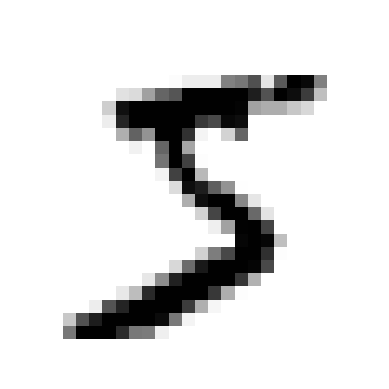

In [7]:
import matplotlib.pyplot as plt
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [8]:
y[0]

'5'

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

2진 분류기 훈련

In [10]:
y_train_5 = (y_train == "5") # 5는 True, 나머지 = False
y_test_5 = (y_test == "5")

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

성능 측정

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [14]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)

print(any(dummy_clf.predict(X_train)))

False


In [15]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

분류기의 성능을 평가하는데는 정확도를 사용하지 않는다.
분류기의 성능을 평가할때 confusion matrix를 사용한다.

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

cross_val_predict() 함수는 k-폴드 교차 검증을 수행하지만, 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환한다.
- 즉, 훈련 세트의 모든 샘플에 대해 보지 못했던 데이터에 대한 예측을 얻게 된다.

In [17]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Confusion Matrix
- 행은 실제 클래스
    - 첫 번째 행은 5가 아닌(negative class)에 대한 것
        - 53892개를 5가 아님으로 정확하게 분류
        - 687개는 5라고 잘못 분류(1종 오류)
    - 두 번째 행은 5인(positive class) 것
        - 1891개를 5가 아님으로 잘못 분류(false negative) (2종 요류)
        - 3530개를 정확히 5라고 분류(true positive)
    - 완벽한 분류기라면 Identity Matrix가 반환됨(대각선만 값을 가지고 나머지는 0)
- 열은 예측한 클래스

In [18]:
y_train_perfect_predictions = y_train_5 # 완벽한 분류기
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

정밀도(precision) = 양성 예측의 정확도
TP / (TP + FP)
- TP = 진짜 양성의 수
- FP = 거짓 양성의 수

재현율(recall) = 분류기가 정확하게 감지한 양성 샘플의 비율 = 민감도(sensitivity) = 진짜 양성 비율(TPR: true positive rate)
TP / (TP + FN)
- FN = 거짓 음성의 개수

In [19]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # 3530 / (687 + 3530)

0.8370879772350012

In [20]:
recall_score(y_train_5, y_train_pred) # 3530 / (1891 + 3530)

0.6511713705958311

F1 score
- 정밀도와 재현율을 합침(정밀도와 재현율의 조화 평균)
    - 조화 평균은 낮은 값에 훨씬 더 높은 비중을 둔다.
- 두개의 분류기를 비교할때 많이 사용

In [21]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

decision_funciton() 메서드를 호출하면 각 샘플의 점수를 얻을 수 있다.
이 점수를 기반으로하여 원하는 임계값을 정해 예측을 만들 수 있다.

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [23]:
threshold = 0 # SGD classifier의 임계값이 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [24]:
threshold = 3000 # SGD classifier의 임계값 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

임계값이 높아지면 재현율(recall)이 줄어든다.

적절한 임계값 구하기
1. cross_val_predict()를 사용하여 훈련 세트에 있는 모든 샘플의 점수를 구한다.
- 단, 예측 결과가 아닌 결정 점수를 반환하도록 지정한다.
2. 구한 점수로 precision_recall_curve()를 사용하여 모든 임계값에 대한 정밀도와 재현율을 계산한다.
- 이 함수는 무한한 임계값에 해당하는 값으로, 마지막 정밀도에 1을 마지막 재현율에 0을 추가한다.

In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

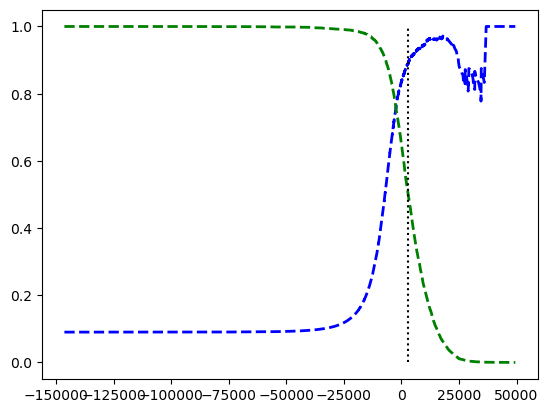

In [27]:
plt.plot(thresholds, precisions[:-1], "b--", label="정밀도", linewidth = 2)
plt.plot(thresholds, recalls[:-1], "g--", label="재현율", linewidth = 2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="임계값")

plt.show()

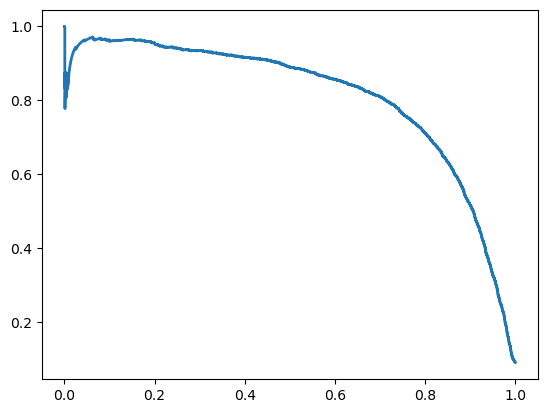

In [28]:
plt.plot(recalls, precisions, linewidth=2, label="정밀도/재현율 곡선")
plt.show()

ex
- 정밀도 90% 달성이 목표
1. 그래프에서 사용할 임계값을 찾을 수 있다.
2. 정밀도가 최소 90%가 되는 가장 낮은 임계값을 찾는다.
- 넘파이의 argmax() 메서드를 사용한다.
    - 이 메서드는 최댓값의 첫 번째 인덱스를 반환한다.

In [29]:
idx_for_90_precision = (precisions >= 0.9).argmax()
print(thresholds)
threshold_for_90_precision = thresholds[idx_for_90_precision]
print(threshold_for_90_precision)

[-146348.56726174 -142300.00705404 -137588.97581744 ...   38871.26391927
   42216.05562787   49441.43765905]
3370.0194991439594


훈련 세트에 대한 예측을 만들려면 predict()를 호출하는 대신 아래 코드를 실행한다.

In [30]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [31]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

정밀도가 90%이지만, 재현율이 48%이기에 좋지 않다.

In [32]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

ROC 곡선
- 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR)
    - FPR = 양성으로 잘못 분류된 음성 샘플의 비율
        - 1에서 진짜 음성 비율(TNR)을 뺀 값
            - TNR = 특이도(specificity)
    - 즉, ROC 곡선은 민감도(재현율)에 대한 1-특이도 그래프이다.

In [33]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

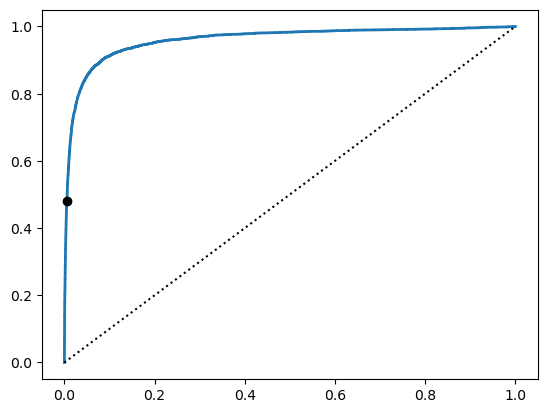

In [34]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth=2, label="ROC 곡선")
plt.plot([0, 1], [0, 1], "k:", label="랜덤 분류기의 ROC 곡선")
plt.plot([fpr_90], [tpr_90], "ko", label="90% 정밀도에 대한 임계값")
plt.show()

곡선 아래의 면적(AUC: Area Under the Curve)을 측정하여 분류기들을 비교할 수 있다.
- 완벽한 분류기는 ROC의 AUC가 1이다.
- 완전한 랜덤 분류기는 0.5이다.

In [35]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

양성 클래스가 드물거나, 거짓 음성보다 거짓 양성이 더 중요할 때 PR 곡선을 사용하고, 그렇지 않으면 ROC곡선을 사용한다.

RandomForestClassifier를 만들어 SGDClassifier의 PR 곡선과 F1 score를 비교한다.

In [36]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

cross_val_predict() 함수를 호출하여 교차 검증으로 RandomForestClassifier를 훈련하고, 모든 이미지에 대한 클래스 확률을 예측할 수 있다.

In [37]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

훈련 세트에 있는 처음 2개의 이미지에 대한 클래스 확률 확인

In [38]:
y_probas_forest[:2]
# 첫 번째 이미지를 89%로 양성이라 예측
# 두 번째 이미지를 99%로 음성이라 예측
# binary classifier이기에 각 행의 확률을 더하면 100%이다.

array([[0.11, 0.89],
       [0.99, 0.01]])

두 번째 열에 양수 클래스에 대한 추정 확률이 포함되어 있으므로 이를 precision_recall_curve()에 전달한다.

In [39]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

PR 곡선을 그려 비교

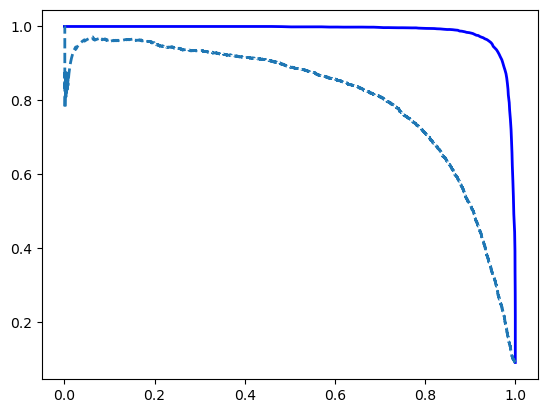

In [40]:
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="랜덤 포레스트")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.show()

랜덤 포레스트의 PR 곡선이 오른쪽 위 모서리에 훨씬 가까워 AUC가 높다.
즉, SGD 보다 랜덤 포레스트의 결과가 더 좋다.

아래의 코드는 F1 score와 ROC AUC점수 비교이다.

In [41]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5 # 양성 클래스 확률 >= 50%
print(f1_score(y_train_5, y_train_pred_forest))
print(roc_auc_score(y_train_5, y_scores_forest))

0.9274509803921569
0.9983436731328145


__지금까지 한것__
1. 이진 분류기 훈련
2. 작업에 맞는 적절한 지표 선택
3. 교차 검증을 사용하여 평가
4. 요구 사항에 맞는 정밀도/재현율 트레이드오프 선택
5. 여러 가지 지표와 곡선을 사용하여 여러 모델 비교

다중분류

OvR(one-versus-the-rest)
- 분류할 때 각 분류기의 결정 점수 중 가장 높은 것을 클래스로 선택한다.

OvO(one-versus-one)
- 0과 1 구별, 0과 2 구별, 1과 2 구별 등과 같이 각 숫자의 조합마다 이진 분류기를 훈련시키는 방법이다.
- 클래스가 N개라면 N x (N - 1) / 2개가 필요하다.
    - 분류기를 모두 통과시켜 가장 많이 양성으로 분류된 클래스를 선택한다.
- OvO 전략의 장점은 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 있으면 된다는 것이다.

- 일부 알고리즘(SVM)은 훈련 세트의 크기에 민감해서 큰 훈련 세트에서 몇 개의 분류기를 훈련시키는 것보다 작ㅇ느 훈련 세트에서 많은 분류기를 훈련시키는 쪽이 빠르므로 OvO를 선호한다.
    - 하지만, 대부분의 이진 분류 알고리즘에서는 OvR을 선호한다.

In [42]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000]) # y_train_5가 아닌 y_train을 사용한다.

SVC(random_state=42)

In [43]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

decision_function()을 호출하면 샘플마다 총 10개의 점수를 반환하는 것을 볼 수 있다.
- 아래 코드에서 가장 높은 것은 9.3점이며, 이는 클래스 5에 해당한다.

In [44]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [45]:
class_id = some_digit_scores.argmax()
class_id

5

분류기가 훈련될 때 classes_ 속성에 타깃 클래스의 리스트를 값으로 정렬하여 저장한다.

In [46]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [47]:
svm_clf.classes_[class_id]

'5'

사이킷런에서 OvO나 OvR을 사용하도록 강제하려면 OneVsOneClassifier나 OneVsRestClassifier를 사용한다.
간단하게 이진 분류기 인스턴스를 만들어 객체를 생헝할 때 전달하면 된다.
- 이진 분류기일 필요도 없다.

아래의 코드는 SVC를 기반으로 OvR 전략을 사용하는 다중 분류기이다.

In [48]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

예측ㅁ을 만들고, 휸련된 분류기의 계수 확인

In [49]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [50]:
len(ovr_clf.estimators_)

10

다중 분류 데이터셋에서 SGDClassifier를 훈련하고 예측을 만든다.

In [51]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

클래스 3이 +1824, 클래스 5가 -1386이기에 오류가 발생했다.

이전처럼 cross_val_score()를 사용하여 모델을 평가한다.

In [52]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [53]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

모든 테스트 폴드에서 85.8% 이상을 얻었다.
랜덤 분류기를 사용했다면 10% 정확도를 얻었을 것이므로, 이 점수가 아주 나쁘지는 않지만 성능을 더 높일 수 있는 여지가 있다.
- 예를 들어 입력 스케일을 조정하면 정확오를 89.1% 이상으로 높일 수 있다.

In [54]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

오류 분석

cross_val_predict() 함수를 사용하여 예측을 만들고 confusion_matrix()를 호출한다.
그 후 앞에서 했던 것처럼 confusion_matrix()함수에 레이블과 예측을 전달한다.
- 하지만, 클래스가 2개가 아니라 10개이기에 오차 행렬에서 상당히 많은 숫자가 포함되므로 읽기 어려울 수 있다.

오차 행렬을 컬러 그래프로 나타내면 분석하기가 훨씬 쉽다.
그래프를 그리려면 다음과 같이 ConfusionMatrixDisplay.from_predictions()를 사용하면 된다.

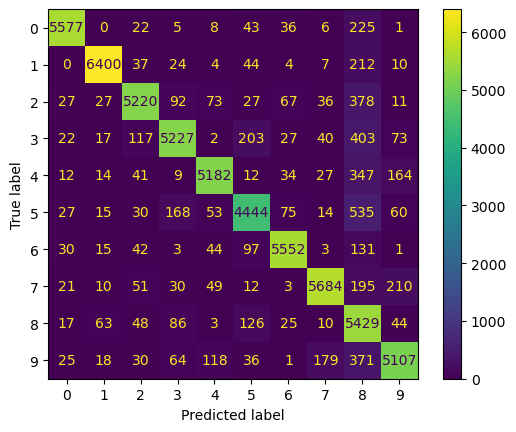

In [55]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

Confusion Matrix 보기 좋게 정규화

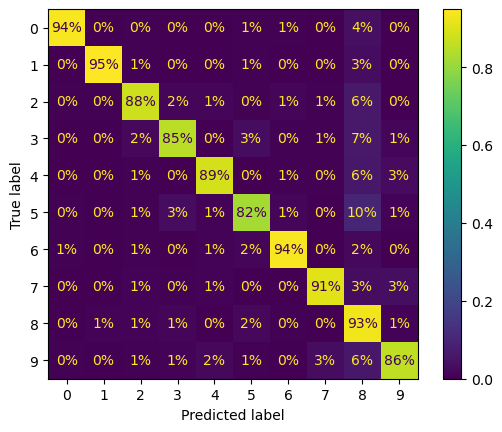

In [56]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", values_format=".0%")

오류를 더 눈에 띄게 만들고 싶다면 올바른 예측에 대한 가중치를 0으로 설정해야 한다.
- 아래의 코드는 이 작업을 수행한다.

- 클래스 8의 열이 매우 밝아진 것으로 보아 많은 이미지가 8로 잘못 분류되었음을 알 수 있다.

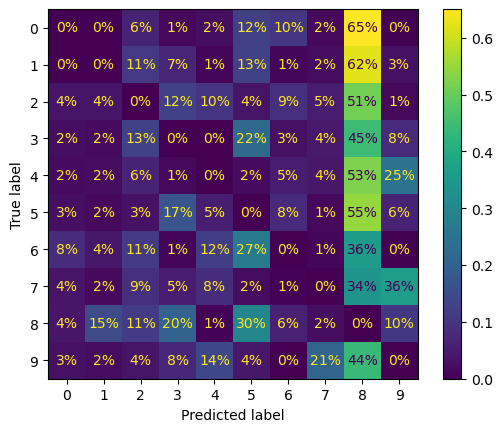

In [57]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(
    y_train, y_train_pred, sample_weight = sample_weight, normalize="true", values_format=".0%"
)
plt.show()

오차 행렬 스타일로 3과 5의 샘플을 그린다.

In [58]:
cl_a, cl_b = "3", "5"
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

다중 레이블 분류(Multilabel classification)

In [61]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= "7")
y_train_odd = (y_train.astype("int8") % 2 == 1)
y_multilabel=np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [62]:
knn_clf.predict([some_digit])

array([[False,  True]])

support를 가중치로 두기 위해선
f1_score() 함수를 호출할 때 average를 weighted로 설정한다.
- f1_score(average="weighted")

In [64]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

In [65]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [66]:
chain_clf.predict([some_digit])

array([[0., 1.]])

다중 출력 다중 클래스 분류

In [67]:
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

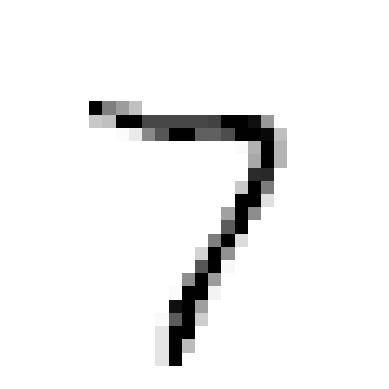

In [68]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()